In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 


## READ IN DATA

In [2]:
svm_df = pd.read_csv('./data/svm.csv',header=None)
lda_df = pd.read_csv('./data/lda.csv', header=None)

In [3]:
svm_df.head()

,0,1,2,3,4
0,600.0,0.5,0.0100,0.27620,191.980
1,900.0,0.8,0.1000,0.27420,99.976
2,2000.0,5.0,0.1000,0.27910,114.410
3,5000.0,1.0,0.0001,0.25770,748.726
4,1.0,5.0,0.0001,0.28714,1048.862


In [4]:
lda_df.head()

,0,1,2,3,4
0,1.0,4.0,16.0,2014.255351,36393.19
1,0.9,1024.0,4096.0,1680.540179,36419.51
2,0.6,1024.0,4096.0,1328.191297,24219.85
3,0.6,16.0,4.0,2859.440420,18862.01
4,0.7,1.0,4096.0,1313.263743,11218.42


## VISULAISE DATA

#### Make a heatmap of the value of the Goldstein–Price function over the domain X= [−2,2] × [−2,2] using a dense grid of values, with 1000 values per dimension, forming a 1000 ×1000 image.

In [79]:
x = np.linspace(-2,2,1000)
y = np.linspace(-2,2,1000)
x, y = np.meshgrid(x, y)

Z = (1+(x+y+1)**2*(19-14*x+3*x**2-14*y+6*x*y+3*y**2))*(30+(2*x-3*y)**2*(18-32*x+12*x**2+48*y-36*x*y+27*y**2))  

plt.scatter(x, y, c=Z, cmap='jet',vmin=Z.min(), vmax=Z.max())
plt.colorbar()
plt.grid()
plt.show()

KeyboardInterrupt: 

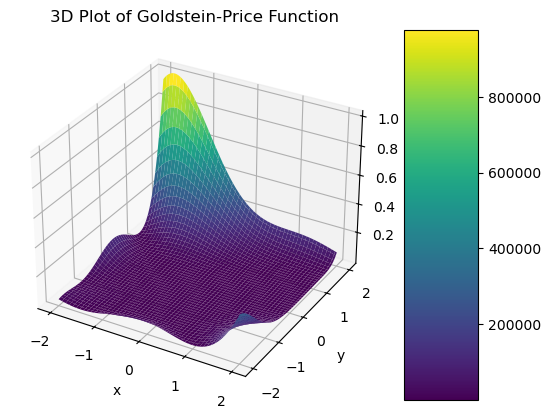

In [81]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def goldstein_price(x, y):
    u = 1 + (x + y + 1)**2 * (19 - 14*x + 3*x**2 - 14*y + 6*x*y + 3*y**2)
    v = 30 + (2*x - 3*y)**2 * (18 - 32*x + 12*x**2 + 48*y - 36*x*y + 27*y**2)
    return u * v

x = np.linspace(-2, 2, 100)
y = np.linspace(-2, 2, 100)
X, Y = np.meshgrid(x, y)

Z = goldstein_price(X, Y)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')


surf = ax.plot_surface(X, Y, Z, cmap='viridis')


ax.set_xlabel('x')
ax.set_ylabel('y')
plt.title('3D Plot of Goldstein-Price Function')


fig.colorbar(surf, aspect=5)

plt.show()

In [48]:
ax

<Axes3D: title={'center': '3D Plot of Goldstein-Price Function'}, xlabel='x', ylabel='y', zlabel='Z'>

#### Describe the behavior of the function. Does it appear stationary? (That is, does the behavior of the function appear to be relatively constant throughout the domain?)

#### Can you find a transformation of the data that makes it more stationary?

#### Make a kernel density estimate of the distribution of the values for the lda and svm bench- marks. Interpret the distributions.

In [1]:
from sklearn.neighbors import KernelDensity
import seaborn as sns

plt.figure("HISTOGRAM_SVM")


data = svm_df[4].to_numpy()

# Create the figure
plt.figure(figsize=(10, 6))
plt.title("Data Distribution with KDE")

# Plot the histogram of the data (distribution)
sns.kdeplot(data, fill=True, color='blue', label='KDE')
sns.histplot(data, kde=False, bins=100, color='red', stat='density', alpha=0.5, label="Data Distribution")

# Show the plot
plt.xlabel("Value")
plt.ylabel("Density")
plt.legend()
plt.show()


NameError: name 'plt' is not defined

<Figure size 640x480 with 0 Axes>

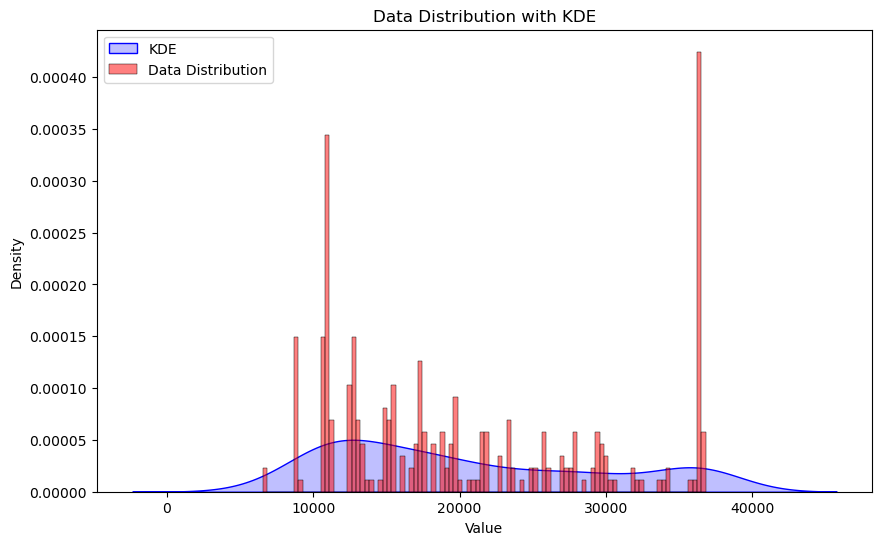

In [ ]:
from sklearn.neighbors import KernelDensity
import seaborn as sns

plt.figure("HISTOGRAM_LDA")


data = lda_df[4].to_numpy()

# Create the figure
plt.figure(figsize=(10, 6))
plt.title("Data Distribution with KDE")

# Plot the histogram of the data (distribution)
sns.kdeplot(data, fill=True, color='blue', label='KDE')
sns.histplot(data, kde=False, bins=100, color='red', stat='density', alpha=0.5, label="Data Distribution")

# Show the plot
plt.xlabel("Value")
plt.ylabel("Density")
plt.legend()
plt.show()


#### Again, can you find a transformation that makes the performance better behaved?

## Model fitting

#### Select a set of 32 training points for the Goldstein–Price function in the domain X= [−2,2] ×[−2,2] using a Sobol sequence. This is a so-called low-discrepancy sequence that produces “quasirandom” points that fill the space relatively evenly; see the Wikipedia article for more information, and note that this should be built into most scientific software. Measure the function at these locations to form a dataset D.

In [ ]:
from scipy.stats import qmc
domain = [-2, 2]
sampler = qmc.Sobol(d=2, scramble=True)
samples = sampler.random_base2(m=5)
scaled_samples = domain[0] + (domain[1] - domain[0]) * samples
x,y = scaled_samples[:,0], scaled_samples[:,1]
X_train = scaled_samples
X = np.linspace(0, len(X_train)-1, len(X_train))
Y_train = (1+(x+y+1)**2*(19-14*x+3*x**2-14*y+6*x*y+3*y**2))*(30+(2*x-3*y)**2*(18-32*x+12*x**2+48*y-36*x*y+27*y**2))  
Y_train.mean()

58795.296167975845

#### Fit a Gaussian process model to the data using a constant mean and a squared exponential covariance. As the output of a deterministic computer program, there is no “noise” in our observations, so we should fix the standard deviation of the noise to a small value such as 0.001. This is possible in most gp software packages. Maximize the marginal likelihood of the data as a function of the hyperparameters: constant mean value and the length scale and output scale of the covariance function.

In [58]:
import pymc as pm

with pm.Model() as model:
    # Hyperparameters: Constant mean, length scale, and output scale
    mean_const = pm.Normal("mean_const", mu=0, sigma=5)
    length_scale = pm.Gamma("length_scale", alpha=2, beta=1)
    output_scale = pm.HalfNormal("output_scale", sigma=5)
    
    # Squared Exponential (RBF) covariance function
    cov_func = output_scale**2 * pm.gp.cov.ExpQuad(2, ls=length_scale)
    
    # Define the GP using the mean and covariance function
    gp = pm.gp.Marginal(mean_func=pm.gp.mean.Constant(mean_const), cov_func=cov_func)
    
    # Fix the noise variance to 0.001**2
    sigma_n = 0.001
    y_obs = gp.marginal_likelihood("y_obs", X=X_train, y=Y_train, noise=sigma_n)

    # Step 3: Optimize the model (find the MAP estimates)
    map_estimate = pm.find_MAP()

    print("MAP estimates:")
    print(f"Mean: {map_estimate['mean_const']}")
    print(f"Length scale: {map_estimate['length_scale']}")
    print(f"Output scale: {map_estimate['output_scale']}")

    # Step 4: Sample from the posterior for predictions
    trace = pm.sample(1000, tune=1000, return_inferencedata=True)




/opt/anaconda3/lib/python3.12/site-packages/pymc/gp/gp.py:56: FutureWarning: The 'noise' parameter has been been changed to 'sigma' in order to standardize the GP API and will be deprecated in future releases.
  warnings.warn(_noise_deprecation_warning, FutureWarning)


Output()

MAP estimates:
Mean: 2.127763633649469e-05
Length scale: 0.4847990167750156
Output scale: 1805.2802540180035


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mean_const, length_scale, output_scale]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 6 seconds.


(10000,)

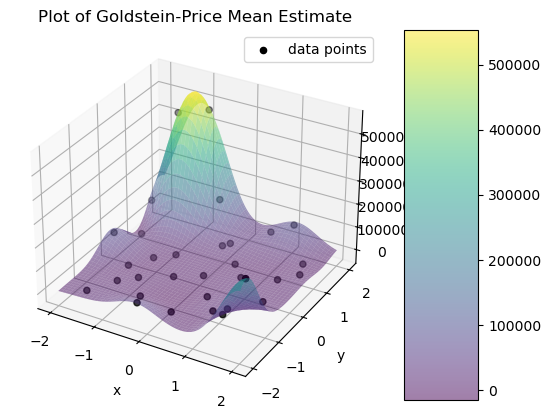

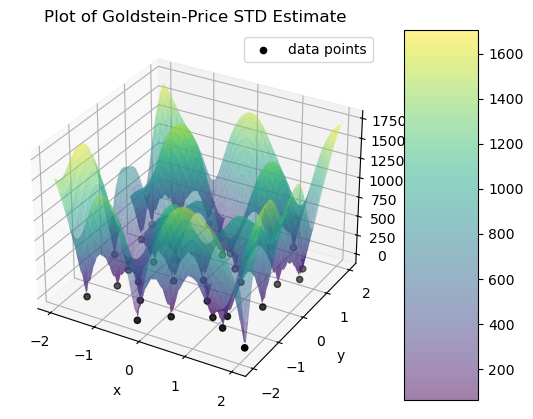

In [96]:
x1_range = np.linspace(-2, 2, 100)
x2_range = np.linspace(-2, 2, 100)
X1, X2 = np.meshgrid(x1_range, x2_range)
X_pred = np.column_stack([X1.ravel(), X2.ravel()])

with model:
    mu, var = gp.predict(X_pred, point=map_estimate, diag=True)
    std = np.sqrt(var)

##MEAN

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(X1, X2, mu.reshape((len(X1), len(X2))), cmap='viridis', alpha = 0.5)
ax.scatter(X_train[:,0], X_train[:,1],Y_train, color = 'black' ,label = 'data points')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend()

plt.title('Plot of Goldstein-Price Mean Estimate')


fig.colorbar(surf, aspect=5)

plt.show()

##STD

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(X1, X2, std.reshape((len(X1), len(X2))), cmap='viridis', alpha = 0.5)
ax.scatter(X_train[:,0], X_train[:,1],0, color = 'black', label = 'data points')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend()

plt.title('Plot of Goldstein-Price STD Estimate')


fig.colorbar(surf, aspect=5)

plt.show()





